Data sample:
          name                  date_utc  success                    rocket  \
0    FalconSat  2006-03-24T22:30:00.000Z    False  5e9d0d95eda69955f709d1eb   
1      DemoSat  2007-03-21T01:10:00.000Z    False  5e9d0d95eda69955f709d1eb   
2  Trailblazer  2008-08-03T03:34:00.000Z    False  5e9d0d95eda69955f709d1eb   
3       RatSat  2008-09-28T23:15:00.000Z     True  5e9d0d95eda69955f709d1eb   
4     RazakSat  2009-07-13T03:35:00.000Z     True  5e9d0d95eda69955f709d1eb   

                  launchpad rocket_name   launchpad_name  year  month  
0  5e9e4502f5090995de566f86    Falcon 1  Kwajalein Atoll  2006      3  
1  5e9e4502f5090995de566f86    Falcon 1  Kwajalein Atoll  2007      3  
2  5e9e4502f5090995de566f86    Falcon 1  Kwajalein Atoll  2008      8  
3  5e9e4502f5090995de566f86    Falcon 1  Kwajalein Atoll  2008      9  
4  5e9e4502f5090995de566f86    Falcon 1  Kwajalein Atoll  2009      7  

Class distribution:
success
True     88.292683
False    11.707317
Name: proport

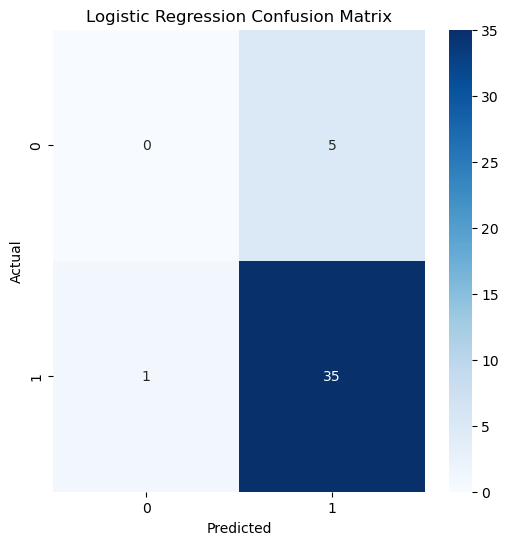

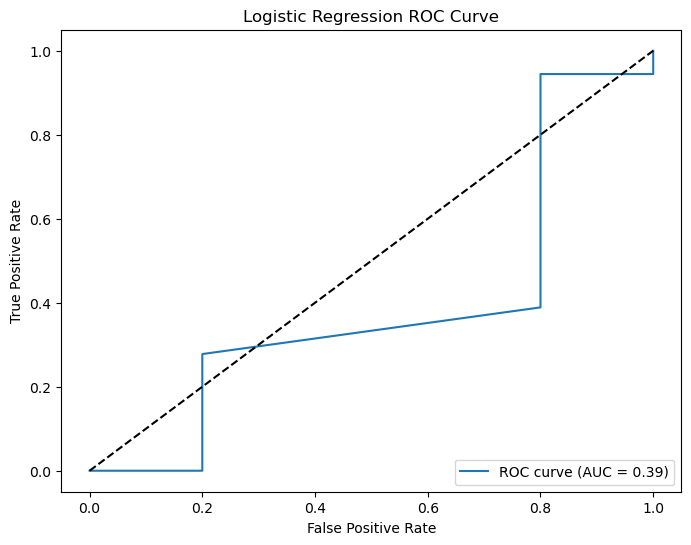


Random Forest Classification Report:
              precision    recall  f1-score   support

       False       0.50      0.20      0.29         5
        True       0.90      0.97      0.93        36

    accuracy                           0.88        41
   macro avg       0.70      0.59      0.61        41
weighted avg       0.85      0.88      0.85        41



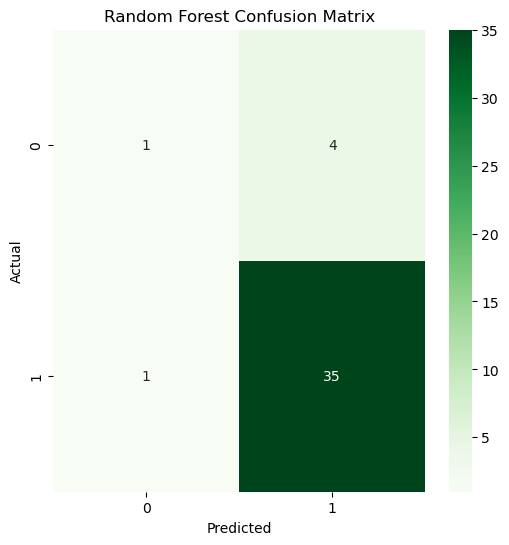

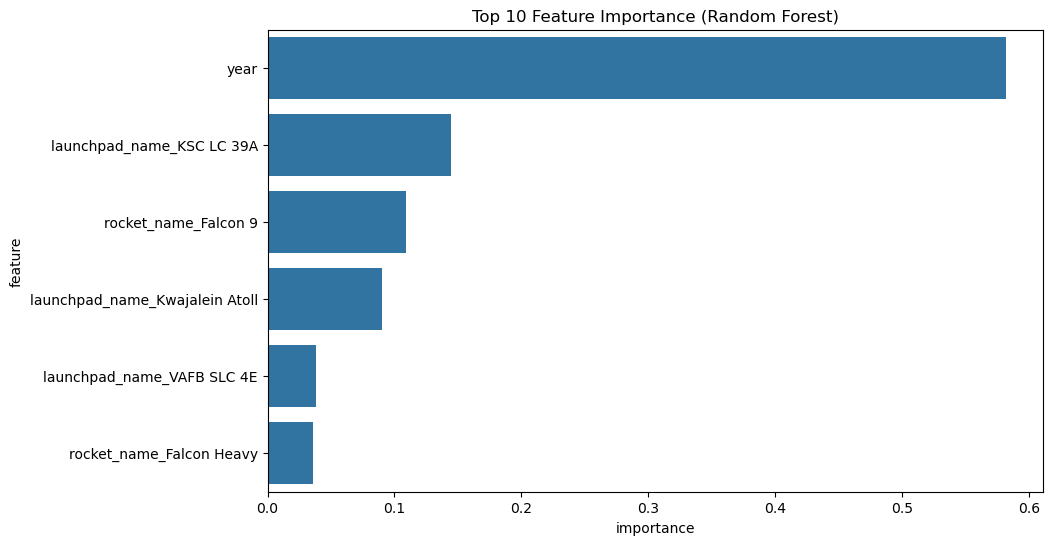


Logistic Regression (Balanced) Classification Report:
              precision    recall  f1-score   support

       False       0.11      0.80      0.20         5
        True       0.83      0.14      0.24        36

    accuracy                           0.22        41
   macro avg       0.47      0.47      0.22        41
weighted avg       0.75      0.22      0.23        41


Model Summary:
Logistic Regression AUC: 0.38888888888888884
Top features (Random Forest):
                          feature  importance
5                            year    0.581748
2       launchpad_name_KSC LC 39A    0.144575
0            rocket_name_Falcon 9    0.109520
3  launchpad_name_Kwajalein Atoll    0.090433
4      launchpad_name_VAFB SLC 4E    0.037942
Saved test predictions to data/test_predictions.csv


c:\Users\KOVVO\anaconda3\envs\Timo\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("data/spacex_cleaned.csv")
print("Data sample:")
print(df.head())

# Select features and target
features = ["year", "rocket_name", "launchpad_name"]
target = "success"
X = df[features]
y = df[target]

# Check class distribution
print("\nClass distribution:")
print(y.value_counts(normalize=True) * 100)

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), ["rocket_name", "launchpad_name"])
    ],
    remainder="passthrough"
)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("\nTraining set size:", X_train.shape)
print("Test set size:", X_test.shape)

# Logistic Regression
lr_model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(random_state=42))
])
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Logistic Regression Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("presentation/lr_confusion_matrix.png")
plt.show()

# Logistic Regression ROC Curve
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("Logistic Regression ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.savefig("presentation/lr_roc_curve.png")
plt.show()

# Random Forest
rf_model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42, n_estimators=100))
])
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("presentation/rf_confusion_matrix.png")
plt.show()

# Feature Importance
feature_names = (rf_model.named_steps["preprocessor"]
                 .named_transformers_["cat"]
                 .get_feature_names_out(["rocket_name", "launchpad_name"]))
feature_names = np.concatenate([feature_names, ["year"]])
importances = rf_model.named_steps["classifier"].feature_importances_
feature_importance = pd.DataFrame({"feature": feature_names, "importance": importances})
feature_importance = feature_importance.sort_values("importance", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=feature_importance.head(10))
plt.title("Top 10 Feature Importance (Random Forest)")
plt.savefig("presentation/rf_feature_importance.png")
plt.show()

# Logistic Regression with class weights
lr_balanced = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(random_state=42, class_weight="balanced"))
])
lr_balanced.fit(X_train, y_train)
y_pred_balanced = lr_balanced.predict(X_test)
print("\nLogistic Regression (Balanced) Classification Report:")
print(classification_report(y_test, y_pred_balanced))

# Summary
print("\nModel Summary:")
print("Logistic Regression AUC:", roc_auc)
print("Top features (Random Forest):")
print(feature_importance.head())

# Save predictions
test_results = X_test.copy()
test_results["actual"] = y_test
test_results["predicted_lr"] = y_pred_lr
test_results["predicted_rf"] = y_pred_rf
test_results.to_csv("data/test_predictions.csv", index=False)
print("Saved test predictions to data/test_predictions.csv")